In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
train_data= pd.read_csv("C:/Users/hp/Downloads/663e2b6d54457_train_data_with_samplefeatures.csv")
batsman= pd.read_csv("C:/Users/hp/Downloads/663e2b548c98c_batsman_level_scorecard.csv")
bowler= pd.read_csv("C:/Users/hp/Downloads/663e2b2c60743_bowler_level_scorecard.csv")
matchdata= pd.read_csv("C:/Users/hp/Downloads/664389efa0868_match_level_scorecard.csv")
test= pd.read_csv("test1.csv")

In [4]:
matchdata_new= pd.read_csv("matchdata_final.csv")

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
batsman=batsman.drop(['is_bowler_keeper', 'is_bowler_captain', 'is_batsman_captain', 'is_batsman_keeper', 'wicket kind','out_by_fielder','over_faced_first' ], axis=1)

In [8]:
batsman.shape, bowler.shape, matchdata.shape

((24483, 14), (18539, 18), (1689, 30))

In [9]:
batsman['Fours'] = batsman['Fours'].fillna(0)
batsman['Sixes'] = batsman['Sixes'].fillna(0)
batsman['strike_rate'] = batsman['strike_rate'].fillna(0)

In [10]:
def extract_batting_style(text):
    if pd.isna(text):
        return None
    parts = text.split(':')
    if len(parts) > 2:
        return parts[2]
    else:
        return None
batsman['bowler_details'] = batsman['bowler_details'].apply(extract_batting_style)
batsman['batsman_details'] = batsman['batsman_details'].apply(lambda x: x.split(':')[1] if len(x.split(':')) > 1 else None)

In [11]:
batsman.head(2)

,match id,batsman,batsman_id,batsman_details,inning,runs,balls_faced,out_by_bowler,bowler_id,bowler_details,strike_rate,Fours,Sixes,match_dt
0,8638034,KD Ce,7907451.0,Right-hand bat,1,7,5,JS Nm,2486896.0,Right-arm medium-fast,140.0,1.0,0.0,2021-01-01
1,8638034,TL St,4381761.0,Right-hand bat,1,46,46,R Ra,6718382.0,Slow left-arm orthodox,100.0,4.0,1.0,2021-01-01


In [12]:
batsman['boundaries']= batsman['Fours'] + batsman['Sixes']
batsman['boundary_runs']= 4*batsman['Fours'] + 6*batsman['Sixes']
batsman= batsman.drop(['Fours', 'Sixes'], axis=1)

In [13]:
batsman['%boundary']= batsman['boundary_runs']/batsman['runs']

In [14]:
# average strike rate in past 10 matches
#average run percentage in past 10 matches 


In [15]:
bowler.head(2)

,match id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.5,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.5,0,7.0,3,1,2,0,2021-01-01


In [16]:
bowler= bowler.drop(['is_bowler_keeper', 'is_bowler_captain' ], axis=1)

In [17]:
bowler['boundaries']= bowler['Fours'] + bowler['Sixes']
bowler['boundary_runs']= 4*bowler['Fours'] + 6*bowler['Sixes']
bowler= bowler.drop(['Fours', 'Sixes'], axis=1)

In [18]:
bowler['extra']= bowler['wides']+bowler['noballs']
bowler= bowler.drop(['wides', 'noballs'], axis=1)

In [19]:
bowler['bowler_details'] = bowler['bowler_details'].apply(lambda x: x.split(':')[2] if len(x.split(':')) > 2 else None)

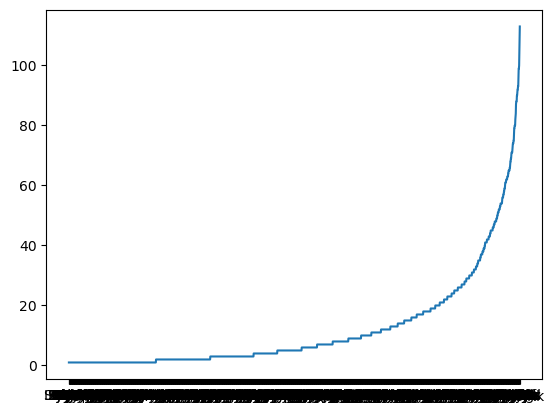

In [20]:
abcd= batsman['batsman'].value_counts().sort_values()
plt.plot(abcd)

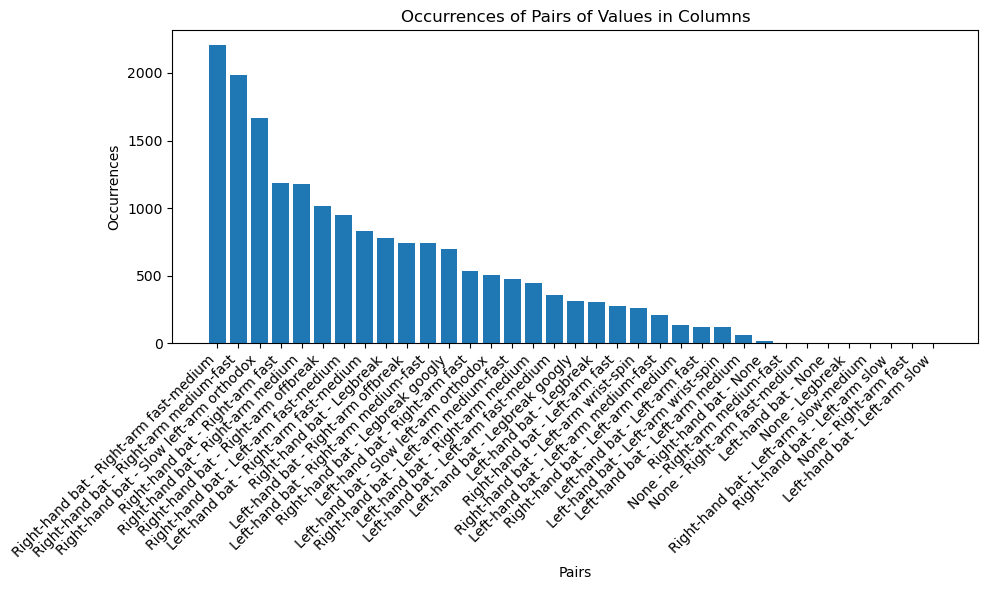

In [21]:
pair_counts = batsman.groupby(['batsman_details', 'bowler_details']).size().reset_index(name='count')
pair_counts= pair_counts.sort_values(by='count', ascending=False)
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(pair_counts['batsman_details'] + ' - ' + pair_counts['bowler_details'], pair_counts['count'])
plt.xlabel('Pairs')
plt.ylabel('Occurrences')
plt.title('Occurrences of Pairs of Values in Columns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    if bat_or_bowl == 'bat':
        df_topick = batsman
        id_col = 'batsman_id'
    else:
        df_topick = bowler
        id_col = 'bowler_id'        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [23]:
def no50sLastn(player_list, date, n):

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.


In [24]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_50runs_last15'] = train_data.apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_count_50runs_last15'] = train_data.apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns

In [25]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
test['team1_count_50runs_last15'] = test.apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team2_count_50runs_last15'] = test.apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team_count_50runs_last15'] = (test['team1_count_50runs_last15']+1)/(test['team2_count_50runs_last15']+1)
test.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns

In [26]:
def boundaries(player_list, date, n):

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['boun'] = df_rel['boundaries'] 
        res_list.append(np.nansum(df_rel['boun']))# Sum up number of bounds for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.


In [27]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_b'] = train_data.apply(lambda x: \
            boundaries(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_b'] = train_data.apply(lambda x: \
            boundaries(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team_boundary_ratios'] = (train_data['team1_b']+1)/(train_data['team2_b']+1)
train_data.drop(columns=['team1_b','team2_b'], inplace=True) # dropping intermediate columns

In [28]:
test['team1_b'] = test.apply(lambda x: \
            boundaries(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team2_b'] = test.apply(lambda x: \
            boundaries(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team_boundary_ratios'] = (test['team1_b']+1)/(test['team2_b']+1)
test.drop(columns=['team1_b','team2_b'], inplace=True) # dropping intermediate columns

In [29]:
def batsman_strk(player_list, date, n):

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list[:6]: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['strr'] = df_rel['strike_rate'] 
        res_list.append(np.nansum(df_rel['strr']))# Sum up number of bounds for the player and append to a list. We will do this for all players.
    return np.nanmean(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.


In [30]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_a'] = train_data.apply(lambda x: \
            batsman_strk(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_a'] = train_data.apply(lambda x: \
            batsman_strk(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team_strike_ratios'] = (train_data['team1_a']+1)/(train_data['team2_a']+1)
train_data.drop(columns=['team1_a','team2_a'], inplace=True) # dropping intermediate columns

In [31]:
test['team1_a'] = test.apply(lambda x: \
            batsman_strk(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team2_a'] = test.apply(lambda x: \
            batsman_strk(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team_strike_ratios'] = (test['team1_a']+1)/(test['team2_a']+1)
test.drop(columns=['team1_a','team2_a'], inplace=True) # dropping intermediate columns


In [32]:
def economies(player_list, date, n):

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='field') # getting batting stats from last n games for each player.
        df_rel['econ'] = df_rel['economy']
        res_list.append(np.nansum(df_rel['econ']))# Sum up number of bounds for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.


In [33]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_a'] = train_data.apply(lambda x: \
            economies(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_a'] = train_data.apply(lambda x: \
            economies(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team_econ_ratios'] = (train_data['team1_a']+1)/(train_data['team2_a']+1)
train_data.drop(columns=['team1_a','team2_a'], inplace=True) # dropping intermediate columns

In [34]:
test['team1_a'] = test.apply(lambda x: \
            economies(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team2_a'] = test.apply(lambda x: \
            economies(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team_econ_ratios'] = (test['team1_a']+1)/(test['team2_a']+1)
test.drop(columns=['team1_a','team2_a'], inplace=True) # dropping intermediate columns


In [35]:
def haul3w(player_list, date, n):

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='field') # getting batting stats from last n games for each player.
        df_rel['3whaul'] = np.where(df_rel['wicket_count']>=3, 1, 0) 
        res_list.append(np.nansum(df_rel['3whaul']))# Sum up number of bounds for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.

In [36]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_a'] = train_data.apply(lambda x: \
            haul3w(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_a'] = train_data.apply(lambda x: \
            haul3w(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team_haul3w_ratios'] = (train_data['team1_a']+1)/(train_data['team2_a']+1)
train_data.drop(columns=['team1_a','team2_a'], inplace=True) # dropping intermediate columns

In [37]:
test['team1_a'] = test.apply(lambda x: \
            haul3w(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team2_a'] = test.apply(lambda x: \
            haul3w(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test['team_haul3w_ratios'] = (test['team1_a']+1)/(test['team2_a']+1)
test.drop(columns=['team1_a','team2_a'], inplace=True) # dropping intermediate columns


In [38]:
train_data= train_data.fillna(0)

In [39]:
selected= ['team1_run_rate_season',
       'team2_run_rate_season', 'team1_nrr_season', 'team2_nrr_season',
       'bat_first', 'team1_run_rate_overall', 'team2_run_rate_overall',
       'team1_nrr_overall', 'team2_nrr_overall', 'team1_run_rate_series',
       'team2_run_rate_series', 'team1_nrr_series', 'team2_nrr_series',
       'team1_run_rate_last10', 'team2_run_rate_last10', 'team1_nrr_last10',
       'team2_nrr_last10',
           
       'team1_avgruns_overall','team1_avgruns_season','team1_avgruns_series', 'team1_avgruns_rolling',
       'team2_avgruns_overall','team2_avgruns_season','team2_avgruns_series', 'team2_avgruns_rolling',
       'team2_avgwks_overall','team2_avgwks_season', 'team2_avgwks_series', 'team2_avgwks_rolling',
       'team1_avgwks_overall','team1_avgwks_season', 'team1_avgwks_series', 'team1_avgwks_rolling',
           
       'team1_rwratio_overall', 'team1_rwratio_season', 'team1_rwratio_series',
       'team1_rwratio_rolling', 'team2_rwratio_overall',
       'team2_rwratio_season', 'team2_rwratio_series', 'team2_rwratio_rolling',
           
       'team1_win_percent_overall', 'team1_win_percent_season',
       'team1_win_percent_series', 'team1_win_percent_rolling',
       'team1_victory_by_runs_overall', 'team1_victory_by_wks_overall',
       'team1_victory_by_runs_season', 'team1_victory_by_wks_season',
       'team1_victory_by_runs_series', 'team1_victory_by_wks_series',
       'team1_victory_by_runs_rolling', 'team1_victory_by_wks_rolling',
       'team2_win_percent_overall', 'team2_win_percent_season',
       'team2_win_percent_series', 'team2_win_percent_rolling',
       'team2_victory_by_runs_overall', 'team2_victory_by_wks_overall',
       'team2_victory_by_runs_season', 'team2_victory_by_wks_season',
       'team2_victory_by_runs_series', 'team2_victory_by_wks_series',
       'team2_victory_by_runs_rolling', 'team2_victory_by_wks_rolling']

In [40]:
merged_data = pd.merge(train_data, matchdata_new, on='match id', how='left')
selected_columns = merged_data[selected]
traindata = selected_columns.combine_first(train_data)

In [41]:
traindata.shape, test.shape

((948, 92), (271, 90))

In [42]:
columns_to_reduce = [
    'run_rate_season', 'nrr_season', 'run_rate_overall', 'nrr_overall', 
    'run_rate_series', 'nrr_series', 'run_rate_last10', 'nrr_last10',
    'avgruns_overall', 'avgruns_season', 'avgruns_series', 'avgruns_rolling',
    'avgwks_overall', 'avgwks_season', 'avgwks_series', 'avgwks_rolling',
    'rwratio_overall', 'rwratio_season', 'rwratio_series', 'rwratio_rolling',
    'win_percent_overall', 'win_percent_season', 'win_percent_series', 'win_percent_rolling',
    'victory_by_runs_overall', 'victory_by_wks_overall', 'victory_by_runs_season', 'victory_by_wks_season',
    'victory_by_runs_series', 'victory_by_wks_series', 'victory_by_runs_rolling', 'victory_by_wks_rolling']

In [43]:
# Create new columns by dividing team1 features by team2 features
for feature in columns_to_reduce:
    traindata[f'{feature}_ratio'] = traindata[f'team1_{feature}'] / traindata[f'team2_{feature}']
    test[f'{feature}_ratio'] = test[f'team1_{feature}'] / test[f'team2_{feature}']
# Drop the original columns
for feature in columns_to_reduce:
    traindata.drop([f'team1_{feature}', f'team2_{feature}'], axis=1, inplace=True)
    test.drop([f'team1_{feature}', f'team2_{feature}'], axis=1, inplace=True)



In [44]:
traindata.to_csv('train2.csv', index= False)
test.to_csv('test2.csv', index= False)